In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
os.getcwd()

'/Users/caseyh/Desktop/footyfootyfooty/data_wrangling'

In [150]:
seasons = sorted(os.listdir('/Users/caseyh/Desktop/footyfootyfooty/round_results/'))[-25:-1]

In [151]:
player_files = sorted(os.listdir('/Users/caseyh/Desktop/footyfootyfooty/player_stats/'))[-24:]

In [152]:
player_data = pd.DataFrame({})
for file in player_files:
    path = '/Users/caseyh/Desktop/footyfootyfooty/player_stats/'
    tmp = pd.read_csv(path + file)
    player_data = pd.concat([player_data, tmp])
player_data = player_data.reset_index(drop=True)

In [153]:
season_data = pd.DataFrame({})
for season in seasons:
    path = '/Users/caseyh/Desktop/footyfootyfooty/round_results/'
    tmp = pd.read_csv(path + season)
    season_data = pd.concat([season_data, tmp])
season_data = season_data.reset_index(drop=True)

season_data = season_data.dropna()

In [154]:
season_data['Date'] = season_data['Date'].str.extract(r'(\d{1,2} \w{3})')
season_data['Date'] = season_data['Date'] + ' ' + season_data['year'].apply(str)

In [155]:
def rearrange_date(x):
    return datetime.strptime(x, '%d %b %Y')

In [156]:
season_data['Date'] = season_data['Date'].apply(lambda x: rearrange_date(x))

In [157]:
teams = ['RCH', 'GEE', 'NTH', 'POR', 'GCS', 'MEL', 'GWS', 'HAW', 'STK',
       'CAR', 'BRL', 'COL', 'ADE', 'FRE', 'WBD', 'SYD', 'ESS', 'WCE']

In [158]:
# rearrange game table
output = pd.DataFrame({})
for season in season_data['year'].unique():
    for r in season_data['round'].unique():
        r_season = season_data[(season_data['round'] == r)&(season_data['year']==season)]
        for i,j in [('Home','Away'), ('Away', 'Home')]:
            rounds = pd.DataFrame({})
            rounds['venue'] = r_season['Venue']
            rounds['team'] = r_season[f'{i}']
            rounds['opponent'] = r_season[f'{j}']
            rounds['won'] = np.select([r_season[f'{i} Score'] > r_season[f'{j} Score']], [1],0)
            rounds['loss'] = np.select([r_season[f'{i} Score'] < r_season[f'{j} Score']], [1],0)
            rounds['draw'] = np.select([r_season[f'{i} Score'] == r_season[f'{j} Score']], [1],0)
            rounds['pf'] = r_season[f'{i} Score']
            rounds['pa'] = r_season[f'{j} Score']
            rounds['margin'] = r_season[f'{i} Score'] - r_season[f'{j} Score']
            rounds['year'] = season
            rounds['round'] = r
            rounds['at_home'] = i
            rounds['date'] = r_season['Date']
            
            
            output = pd.concat([output, rounds])

output = output.reset_index(drop = True)
output['round'] = output['round'].str.replace('Round ','R')

In [159]:
output

,venue,team,opponent,won,loss,draw,pf,pa,margin,year,round,at_home,date
0,MCG,MEL,RCH,0,1,0,92.0,94.0,-2.0,2000,R1,Home,2000-03-08
1,Marvel Stadium,ESS,POR,1,0,0,156.0,62.0,94.0,2000,R1,Home,2000-03-09
2,MCG,NTH,WCE,0,1,0,111.0,154.0,-43.0,2000,R1,Home,2000-03-10
3,Domain Stadium,FRE,GEE,0,1,0,107.0,129.0,-22.0,2000,R1,Home,2000-03-11
4,AAMI Stadium,ADE,WBD,0,1,0,108.0,131.0,-23.0,2000,R1,Home,2000-03-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9335,Adelaide Oval,RCH,POR,0,0,0,NaN,NaN,NaN,2023,R24,Away,2023-08-25
9336,SCG,MEL,SYD,0,0,0,NaN,NaN,NaN,2023,R24,Away,2023-08-25
9337,Blundstone Arena,GCS,NTH,0,0,0,NaN,NaN,NaN,2023,R24,Away,2023-08-25
9338,MCG,FRE,HAW,0,0,0,NaN,NaN,NaN,2023,R24,Away,2023-08-25


In [160]:
output['at_home'] = output['at_home'] == 'Home'

# Total Margin by Team

In [72]:
mbt = output.groupby(['year','team','at_home'])['opponent'].count().reset_index()

In [73]:
margin = output.groupby(['date','round','team'])['margin'].mean().reset_index().sort_values(['team','date'], ascending=[True,True])

In [74]:
margin 

,date,round,team,margin
6,2000-03-11,Round 1,ADE,-23.0
24,2000-03-19,Round 2,ADE,-11.0
34,2000-03-25,Round 3,ADE,-11.0
50,2000-04-01,Round 4,ADE,-114.0
66,2000-04-08,Round 5,ADE,-30.0
...,...,...,...,...
9267,2023-07-30,Round 20,WCE,NaN
9279,2023-08-05,Round 21,WCE,NaN
9297,2023-08-12,Round 22,WCE,NaN
9321,2023-08-20,Round 23,WCE,NaN


In [75]:
mbt = pd.DataFrame({})
for team in teams:
    tmp = margin[margin['team']==team].reset_index(drop=True)
    tmp['rolling_margin'] = tmp['margin'].rolling(window=tmp.shape[0], min_periods=0).sum()
    mbt = pd.concat([mbt, tmp])

In [76]:
import seaborn as sns

In [77]:
mbt = mbt.reset_index(drop=True)

In [78]:
mbt

,date,round,team,margin,rolling_margin
0,2000-03-08,Round 1,RCH,2.0,2.0
1,2000-03-16,Round 2,RCH,-43.0,-41.0
2,2000-03-24,Round 3,RCH,-36.0,-77.0
3,2000-04-02,Round 4,RCH,-1.0,-78.0
4,2000-04-09,Round 5,RCH,26.0,-52.0
...,...,...,...,...,...
9335,2023-07-30,Round 20,WCE,NaN,-116.0
9336,2023-08-05,Round 21,WCE,NaN,-116.0
9337,2023-08-12,Round 22,WCE,NaN,-116.0
9338,2023-08-20,Round 23,WCE,NaN,-116.0


In [79]:
import matplotlib.pylab as plt
sns.set_style("whitegrid")

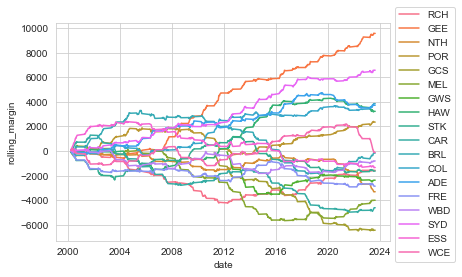

In [80]:
s = sns.lineplot(data=mbt, x='date', y='rolling_margin', hue='team')
s.legend(bbox_to_anchor= (1,1.1))

## Win Percentage

In [24]:
wp = output[['year','team','won','loss','draw','pf','pa','margin']].groupby(['year','team']).sum().reset_index()

In [25]:
wp['win_per']=wp['won']/(wp['loss']+wp['won']+wp['draw'])

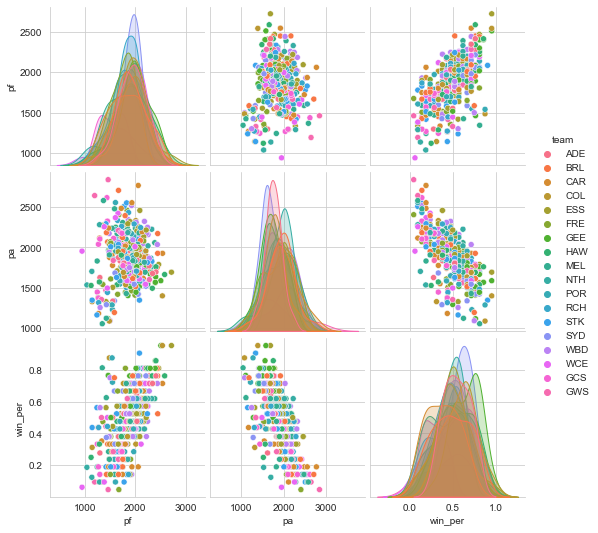

In [29]:
sns.pairplot(data=wp[['team','pf','pa','win_per']],hue='team')

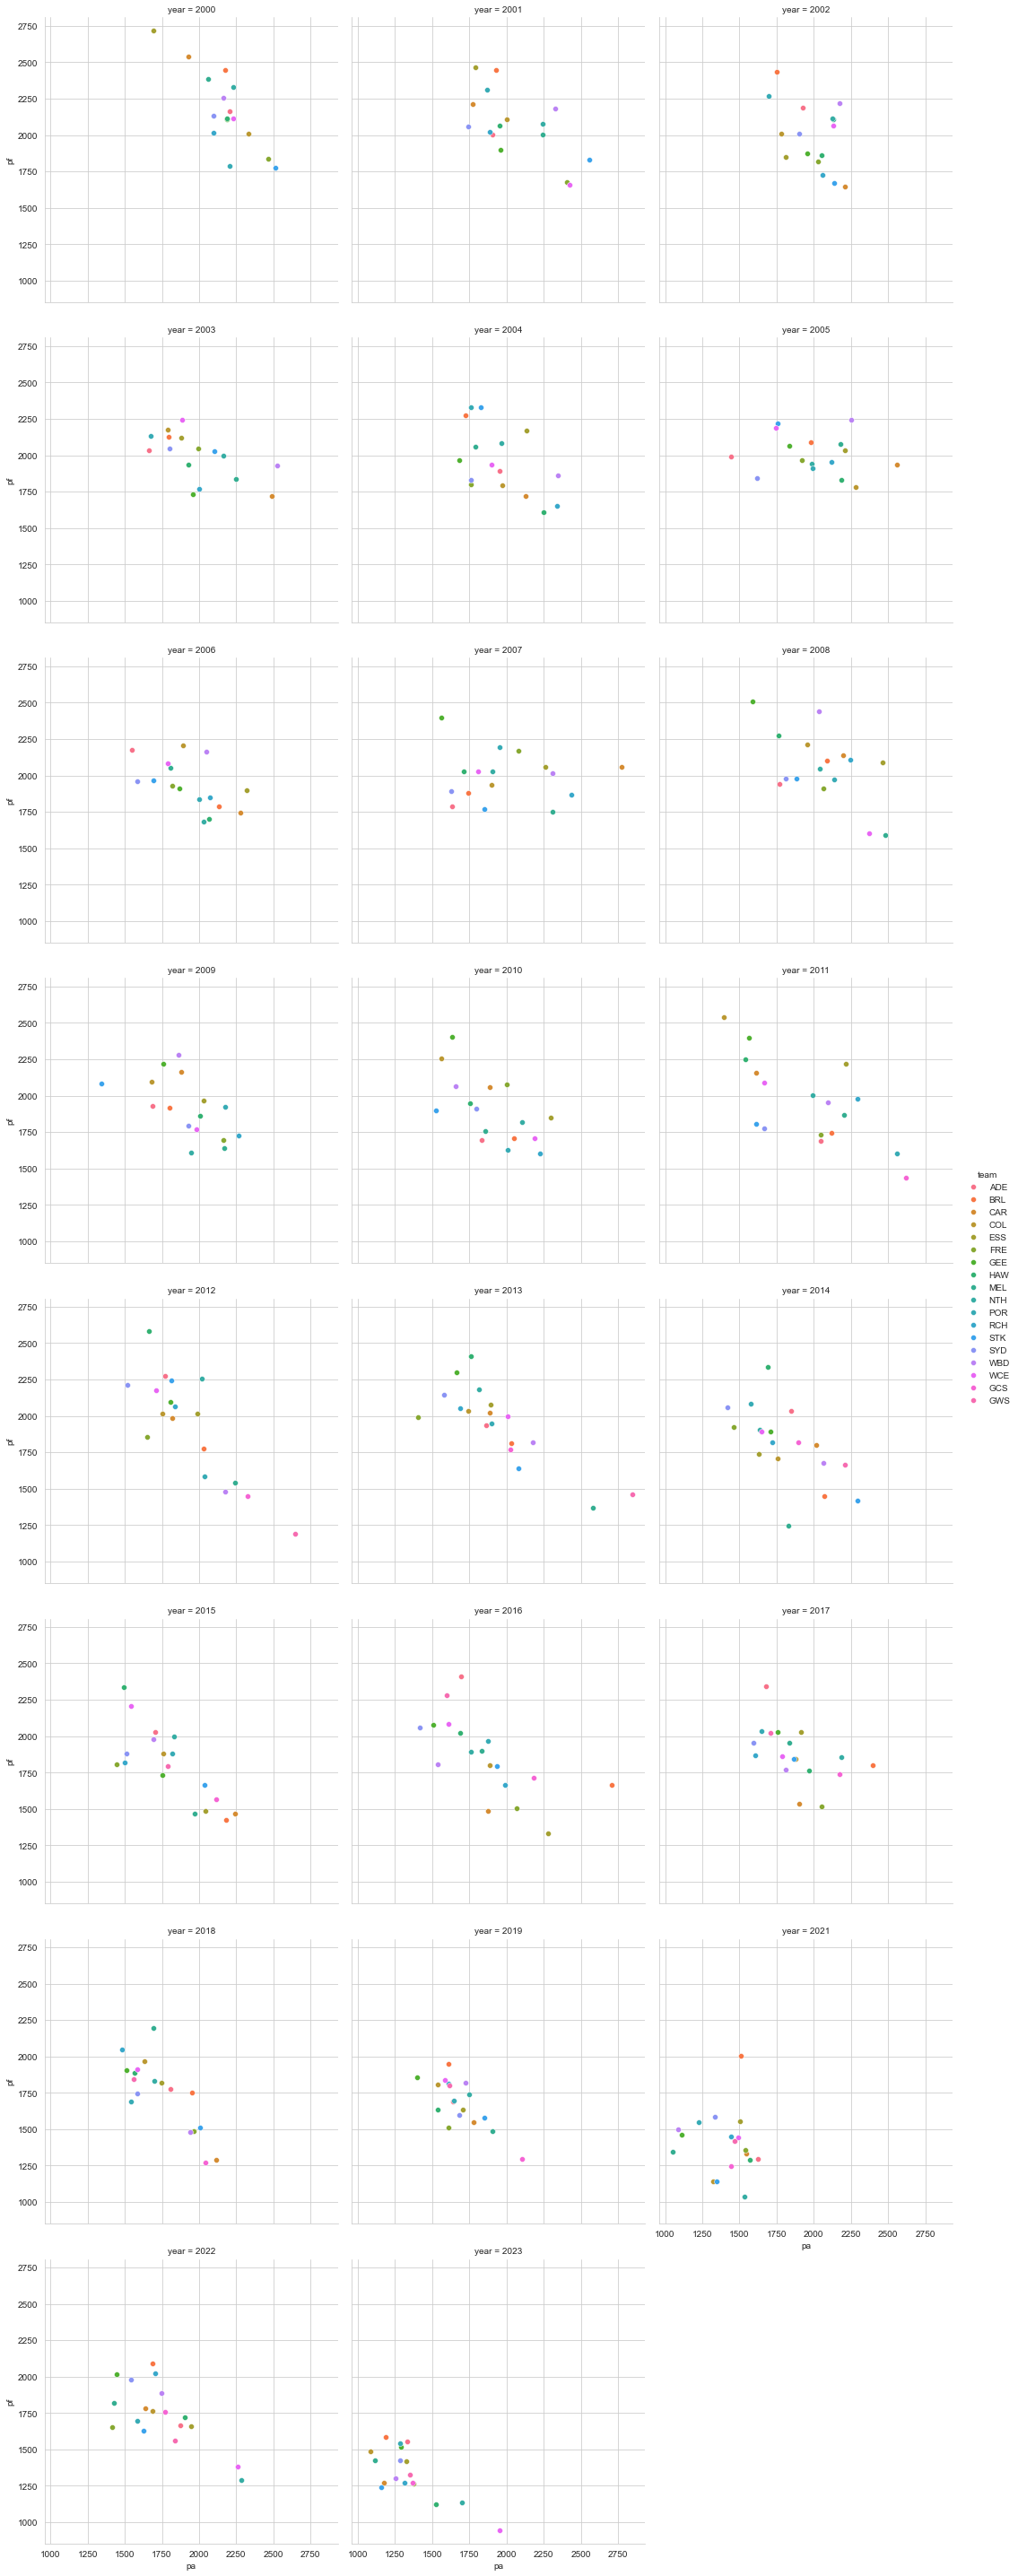

In [38]:
g = sns.FacetGrid(wp[['year','team','pf','pa','win_per']], col="year", hue='team',height=5,col_wrap=3)
g.map(sns.scatterplot,'pa','pf',alpha=1)
g.add_legend()

## Premiers

In [81]:
output.loc[(output['round']=='GF')&(output['won']==1), 'premiers'] = 1
output = output.fillna(0)

In [82]:
prem = output[['year','team','won','loss','draw','pf','pa','margin','premiers']].groupby(['year','team']).sum().reset_index()

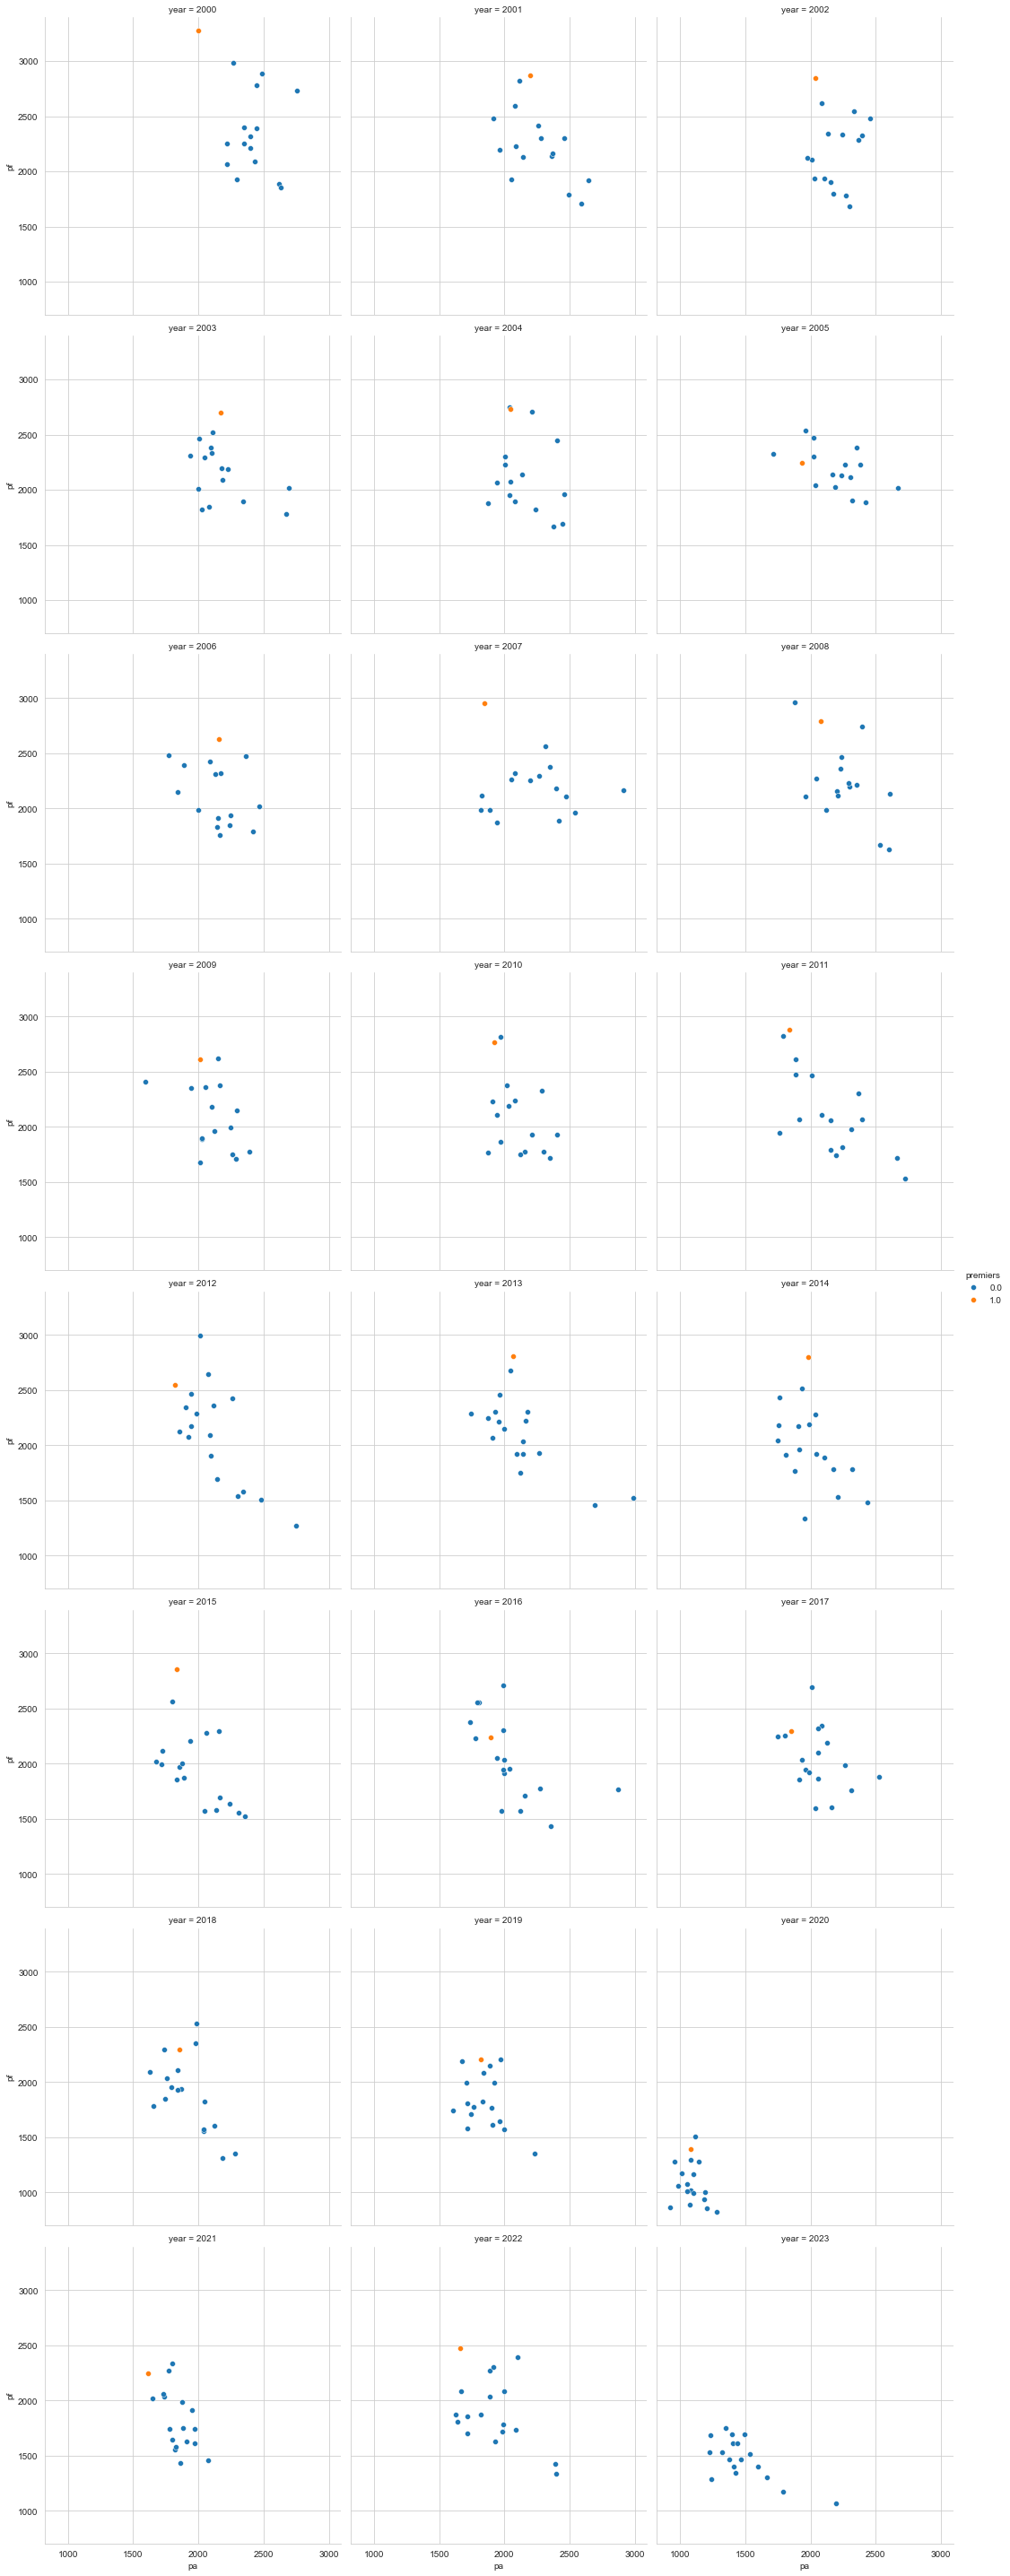

In [83]:
g = sns.FacetGrid(prem[['year','team','pf','pa','premiers']], col="year", hue='premiers',height=5,col_wrap=3)
g.map(sns.scatterplot,'pa','pf',alpha=1)
g.add_legend()

# Player Data

In [161]:
player_data['player_id'] = player_data['Player'] + '_' + player_data['team']

In [162]:
player_data.groupby(['player_id','year']).sum().sort_values('Brownlow Votes',ascending=False).reset_index().head(10)

,player_id,year,Disposals,Kicks,Handballs,Goals,Behinds,Marks,Clearances,Tackles,...,Marks Inside 50,Goal Assists,Frees,Frees Against,Inside 50s,Rebounds,Clangers,One Percenters,Bounces,Brownlow Votes
0,ollie wines_POR,2021,777.0,362.0,415.0,10.0,15.0,100.0,142.0,105.0,...,11.0,14.0,33.0,19.0,125.0,39.0,113.0,30.0,3.0,36.0
1,dustin martin_RCH,2017,744.0,479.0,265.0,37.0,29.0,103.0,160.0,88.0,...,26.0,29.0,37.0,44.0,150.0,23.0,124.0,26.0,24.0,36.0
2,patrick dangerfield_GEE,2016,762.0,387.0,375.0,24.0,24.0,122.0,159.0,109.0,...,18.0,22.0,46.0,30.0,194.0,35.0,92.0,29.0,18.0,35.0
3,dane swan_COL,2011,760.0,472.0,288.0,32.0,23.0,129.0,147.0,77.0,...,19.0,23.0,22.0,17.0,124.0,46.0,78.0,23.0,33.0,34.0
4,patrick dangerfield_GEE,2017,718.0,324.0,394.0,45.0,32.0,109.0,172.0,141.0,...,37.0,20.0,61.0,36.0,127.0,22.0,106.0,25.0,18.0,33.0
5,nat fyfe_FRE,2019,583.0,279.0,304.0,16.0,13.0,96.0,151.0,79.0,...,18.0,13.0,49.0,36.0,94.0,20.0,84.0,43.0,1.0,33.0
6,marcus bontempelli_WBD,2021,695.0,396.0,299.0,31.0,19.0,104.0,143.0,127.0,...,19.0,24.0,41.0,37.0,172.0,50.0,122.0,99.0,28.0,33.0
7,nat fyfe_FRE,2015,576.0,275.0,301.0,17.0,14.0,84.0,173.0,86.0,...,20.0,14.0,23.0,43.0,87.0,24.0,75.0,31.0,7.0,31.0
8,lachie neale_BRL,2020,511.0,249.0,262.0,14.0,13.0,80.0,103.0,59.0,...,8.0,2.0,21.0,12.0,81.0,28.0,52.0,16.0,4.0,31.0
9,clayton oliver_MEL,2021,789.0,358.0,431.0,11.0,18.0,89.0,187.0,136.0,...,6.0,18.0,43.0,46.0,130.0,47.0,129.0,29.0,4.0,31.0


## Team Data

In [247]:
team_data = player_data.groupby(['year','round','team']).sum().reset_index()

In [248]:
team_data[team_data['round']=='GF.1']

,year,round,team,Disposals,Kicks,Handballs,Goals,Behinds,Marks,Clearances,Tackles,Contested Possessions,Uncontested Possessions,Hit Outs,Contested Marks,Marks Inside 50,Goal Assists,Frees,Frees Against,Inside 50s,Rebounds,Clangers,One Percenters,Bounces,Brownlow Votes
3706,2010,GF.1,COL,379.0,250.0,129.0,16.0,8.0,121.0,44.0,87.0,145.0,230.0,49.0,7.0,15.0,10.0,16.0,13.0,55.0,31.0,36.0,59.0,15.0,0.0
3707,2010,GF.1,STK,326.0,178.0,148.0,7.0,9.0,84.0,25.0,67.0,125.0,192.0,26.0,13.0,10.0,5.0,13.0,16.0,39.0,36.0,46.0,46.0,14.0,0.0


In [249]:
output.loc[(output['pf']==output['pa'])&(output['round']=='GF'),'round'] = 'GF.0'

In [250]:
team_data.loc[(team_data['round']=='GF')&(team_data['year']==2010),'round']='GF.0'

In [251]:
team_data.loc[(team_data['round']=='GF.1'),'round']='GF.1'

In [453]:
team_stats = output.merge(team_data, left_on=['year','round','team'], right_on=['year','round','team'])

In [454]:
pd.set_option('display.max_columns', None)

In [455]:
stats = ['pf', 'pa', 'margin', 'Disposals', 'Kicks',
'Handballs', 'Goals', 'Behinds', 'Marks', 'Clearances', 'Tackles',
'Contested Possessions', 'Uncontested Possessions', 'Hit Outs',
'Contested Marks', 'Marks Inside 50', 'Goal Assists', 'Frees',
'Frees Against', 'Inside 50s', 'Rebounds', 'Clangers', 'One Percenters',
'Bounces']

In [456]:
# add in bye rounds
for season in team_stats['year'].unique():
    for r in team_stats[(team_stats['year']==season)&(team_stats['round'].str.contains('R.'))]['round'].unique():
        tmp = team_stats[(team_stats['round']==r)&(team_stats['year']==season)]['team'].unique()
        for team in season_data[season_data['year']==season]['Home'].unique():
            if team not in tmp:
                new_row = pd.DataFrame({'team':team,'pf':0,'pa':0,'round':r,'opponent':'BYE','year':season}, index=[0])
                team_stats = pd.concat([new_row, team_stats])
team_stats = team_stats.reset_index(drop=True)

## Last 5 Stats

In [457]:
team_stats['round'] = pd.Categorical(team_stats['round'], ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11',
       'R12', 'R13', 'R14', 'R15', 'R16', 'R17', 'R18', 'R19', 'R20',
       'R21', 'R22', 'R23', 'R24','EF', 'QF', 'SF', 'PF', 'GF.0','GF'])
team_stats = team_stats.sort_values(['year','round'])

In [458]:
# add last 5 form
l5_avg = pd.DataFrame({})
l5_form = pd.DataFrame({})
for year in range(2000,2024):
    for team in teams:
        tmp = team_stats[(team_stats['year']==year)&(team_stats['team']==team)].sort_values('round')
        # last 5 averages
        l5_avg = pd.concat([l5_avg, tmp[stats].rolling(window=5,min_periods=1,closed='left').mean()])
        
        # last 5 form
        l5_form = pd.concat([l5_form, tmp[['won','loss','draw']].rolling(window=5,min_periods=1,closed='left').sum()])      

In [459]:
team_stats = team_stats.join(l5_form, rsuffix='_l5_form')
team_stats = team_stats.join(l5_avg, rsuffix='_l5_avg')
team_stats = team_stats.reset_index(drop=True)

### Ladder Position

In [460]:
ladder = team_stats[['team','round','year']]

In [461]:
ladder = ladder[~ladder['round'].isin(['EF','QF','SF','PF','GF','GF.0'])].reset_index(drop=True)

In [462]:
ladder = ladder.join(team_stats[~team_stats['round'].isin(['EF','QF','SF','PF','GF','GF.0'])].reset_index(drop=True).groupby(['year','team'])[['won','loss','draw','pf','pa']].cumsum())

In [463]:
ladder['per'] = ladder['pf']/ladder['pa']

In [464]:
ladder = ladder.sort_values(['year','round','won','draw','per'],
                  ascending=[True,True,False,False,False]).reset_index(drop=True)

In [465]:
ladder['position'] = ladder.groupby(['year','round']).won.rank(method="first", ascending=False)

In [466]:
ladder['start_round'] =  ladder['round'].apply(lambda x: 'R'+str(int(x.split('R')[-1])+1) if 'R' in x else '')

# Merge to Table

In [467]:
team_stats = team_stats.merge(ladder[['year','team','start_round','position','per']],
                 left_on=['team','year','round'],right_on=['team','year','start_round'],
                             how='left')

In [477]:
team_stats = team_stats.merge(ladder[['year','team','start_round','position','per']],
                 left_on=['opponent','year','round'],right_on=['team','year','start_round'],
                             how='left',suffixes=['_team','_opp'])

In [482]:
team_stats = team_stats.rename(columns={'team_team':'team'}).drop(columns=['start_round_team','start_round_opp','team_opp'])

In [486]:
team_stats.columns

Index(['team', 'pf', 'pa', 'round', 'opponent', 'year', 'venue', 'won', 'loss',
       'draw', 'margin', 'at_home', 'date', 'Disposals', 'Kicks', 'Handballs',
       'Goals', 'Behinds', 'Marks', 'Clearances', 'Tackles',
       'Contested Possessions', 'Uncontested Possessions', 'Hit Outs',
       'Contested Marks', 'Marks Inside 50', 'Goal Assists', 'Frees',
       'Frees Against', 'Inside 50s', 'Rebounds', 'Clangers', 'One Percenters',
       'Bounces', 'Brownlow Votes', 'won_l5_form', 'loss_l5_form',
       'draw_l5_form', 'pf_l5_avg', 'pa_l5_avg', 'margin_l5_avg',
       'Disposals_l5_avg', 'Kicks_l5_avg', 'Handballs_l5_avg', 'Goals_l5_avg',
       'Behinds_l5_avg', 'Marks_l5_avg', 'Clearances_l5_avg', 'Tackles_l5_avg',
       'Contested Possessions_l5_avg', 'Uncontested Possessions_l5_avg',
       'Hit Outs_l5_avg', 'Contested Marks_l5_avg', 'Marks Inside 50_l5_avg',
       'Goal Assists_l5_avg', 'Frees_l5_avg', 'Frees Against_l5_avg',
       'Inside 50s_l5_avg', 'Rebounds_l5_avg',

In [490]:
opp_stats = team_stats[['team', 'pf', 'pa', 'round', 'opponent','year','won_l5_form', 'loss_l5_form',
       'draw_l5_form', 'pf_l5_avg', 'pa_l5_avg', 'margin_l5_avg',
       'Disposals_l5_avg', 'Kicks_l5_avg', 'Handballs_l5_avg', 'Goals_l5_avg',
       'Behinds_l5_avg', 'Marks_l5_avg', 'Clearances_l5_avg', 'Tackles_l5_avg',
       'Contested Possessions_l5_avg', 'Uncontested Possessions_l5_avg',
       'Hit Outs_l5_avg', 'Contested Marks_l5_avg', 'Marks Inside 50_l5_avg',
       'Goal Assists_l5_avg', 'Frees_l5_avg', 'Frees Against_l5_avg',
       'Inside 50s_l5_avg', 'Rebounds_l5_avg', 'Clangers_l5_avg',
       'One Percenters_l5_avg', 'Bounces_l5_avg']]

In [491]:
team_stats.merge(opp_stats,
                 left_on=['opponent','year','round'],right_on=['team','year','round'],
                             how='left',suffixes=['_team','_opp'])

,team_team,pf_team,pa_team,round,opponent_team,year,venue,won,loss,draw,margin,at_home,date,Disposals,Kicks,Handballs,Goals,Behinds,Marks,Clearances,Tackles,Contested Possessions,Uncontested Possessions,Hit Outs,Contested Marks,Marks Inside 50,Goal Assists,Frees,Frees Against,Inside 50s,Rebounds,Clangers,One Percenters,Bounces,Brownlow Votes,won_l5_form_team,loss_l5_form_team,draw_l5_form_team,pf_l5_avg_team,pa_l5_avg_team,margin_l5_avg_team,Disposals_l5_avg_team,Kicks_l5_avg_team,Handballs_l5_avg_team,Goals_l5_avg_team,Behinds_l5_avg_team,Marks_l5_avg_team,Clearances_l5_avg_team,Tackles_l5_avg_team,Contested Possessions_l5_avg_team,Uncontested Possessions_l5_avg_team,Hit Outs_l5_avg_team,Contested Marks_l5_avg_team,Marks Inside 50_l5_avg_team,Goal Assists_l5_avg_team,Frees_l5_avg_team,Frees Against_l5_avg_team,Inside 50s_l5_avg_team,Rebounds_l5_avg_team,Clangers_l5_avg_team,One Percenters_l5_avg_team,Bounces_l5_avg_team,position_team,per_team,position_opp,per_opp,team_opp,pf_opp,pa_opp,opponent_opp,won_l5_form_opp,loss_l5_form_opp,draw_l5_form_opp,pf_l5_avg_opp,pa_l5_avg_opp,margin_l5_avg_opp,Disposals_l5_avg_opp,Kicks_l5_avg_opp,Handballs_l5_avg_opp,Goals_l5_avg_opp,Behinds_l5_avg_opp,Marks_l5_avg_opp,Clearances_l5_avg_opp,Tackles_l5_avg_opp,Contested Possessions_l5_avg_opp,Uncontested Possessions_l5_avg_opp,Hit Outs_l5_avg_opp,Contested Marks_l5_avg_opp,Marks Inside 50_l5_avg_opp,Goal Assists_l5_avg_opp,Frees_l5_avg_opp,Frees Against_l5_avg_opp,Inside 50s_l5_avg_opp,Rebounds_l5_avg_opp,Clangers_l5_avg_opp,One Percenters_l5_avg_opp,Bounces_l5_avg_opp
0,MEL,92.0,94.0,R1,RCH,2000,MCG,0.0,1.0,0.0,-2.0,True,2000-03-08,272.0,183.0,89.0,13.0,12.0,59.0,37.0,28.0,123.0,145.0,33.0,14.0,10.0,0.0,27.0,36.0,62.0,31.0,39.0,17.0,16.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RCH,94.0,92.0,MEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ESS,156.0,62.0,R1,POR,2000,Marvel Stadium,1.0,0.0,0.0,94.0,True,2000-03-09,349.0,213.0,136.0,24.0,11.0,79.0,28.0,38.0,125.0,217.0,27.0,12.0,18.0,0.0,33.0,15.0,66.0,33.0,42.0,32.0,12.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POR,62.0,156.0,ESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NTH,111.0,154.0,R1,WCE,2000,MCG,0.0,1.0,0.0,-43.0,True,2000-03-10,303.0,204.0,99.0,16.0,15.0,70.0,36.0,20.0,145.0,164.0,33.0,13.0,9.0,0.0,28.0,22.0,55.0,41.0,26.0,29.0,18.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WCE,154.0,111.0,NTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FRE,107.0,129.0,R1,GEE,2000,Domain Stadium,0.0,1.0,0.0,-22.0,True,2000-03-11,337.0,196.0,141.0,16.0,9.0,67.0,44.0,32.0,136.0,196.0,26.0,7.0,8.0,0.0,24.0,26.0,55.0,36.0,48.0,22.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GEE,129.0,107.0,FRE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ADE,108.0,131.0,R1,WBD,2000,AAMI Stadium,0.0,1.0,0.0,-23.0,True,2000-03-11,261.0,166.0,95.0,15.0,16.0,59.0,32.0,25.0,121.0,142.0,21.0,4.0,10.0,0.0,21.0,23.0,55.0,32.0,22.0,22.0,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WBD,131.0,108.0,ADE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

## Add opponent data...

In [484]:
team_stats.to_csv('/Users/caseyh/Desktop/footyfootyfooty/test.csv',index=False)

In [494]:
# general play
team_stats[['Disposals','Kicks','Handballs','Clearances','Tackles','Contested Possessions','Uncontested Possessions','Hit Outs']]

,Disposals,Kicks,Handballs,Clearances,Tackles,Contested Possessions,Uncontested Possessions,Hit Outs
0,272.0,183.0,89.0,37.0,28.0,123.0,145.0,33.0
1,349.0,213.0,136.0,28.0,38.0,125.0,217.0,27.0
2,303.0,204.0,99.0,36.0,20.0,145.0,164.0,33.0
3,337.0,196.0,141.0,44.0,32.0,136.0,196.0,26.0
4,261.0,166.0,95.0,32.0,25.0,121.0,142.0,21.0
...,...,...,...,...,...,...,...,...
9477,361.0,198.0,163.0,43.0,65.0,149.0,203.0,32.0
9478,358.0,218.0,140.0,43.0,86.0,155.0,188.0,37.0
9479,358.0,215.0,143.0,35.0,53.0,128.0,199.0,35.0
9480,438.0,211.0,227.0,37.0,53.0,149.0,291.0,39.0


In [496]:
1.5 * team_stats['Kicks'] + 1 * team_stats['Handballs'] + 1.2 * team_stats['Clearances']

0       407.9
1       489.1
2       448.2
3       487.8
4       382.4
        ...  
9477    511.6
9478    518.6
9479    507.5
9480    587.9
9481    486.1
Length: 9482, dtype: float64

In [ ]:
# discipline
team_stats[['Frees','Fress Against','Clangers','One Percenters']]

In [ ]:
# aerial threat
team_stats[['Marks','Contested Marks','Marks Inside 50']]

In [512]:
team_stats.loc[(team_stats['year']==2007)&(team_stats['round']=='SF')&
               ((team_stats['team']=='COL')),'pf'] = 93
team_stats.loc[(team_stats['year']==2007)&(team_stats['round']=='SF')&
               ((team_stats['team']=='COL')),'pa'] = 74
team_stats.loc[(team_stats['year']==2007)&(team_stats['round']=='SF')&
               ((team_stats['team']=='WCE')),'pf'] = 74
team_stats.loc[(team_stats['year']==2007)&(team_stats['round']=='SF')&
               ((team_stats['team']=='WCE')),'pa'] = 93

In [517]:
# offense
team_stats[['team','year','round','pf','pa','Goals','Behinds','Marks Inside 50','Goal Assists','Inside 50s','rushed behinds']].sort_values('rushed behinds',ascending=False)

,team,year,round,pf,pa,Goals,Behinds,Marks Inside 50,Goal Assists,Inside 50s,rushed behinds
3328,GEE,2008,GF,89.0,115.0,11.0,12.0,13.0,4.0,62.0,11.0
4977,BRL,2013,R3,94.0,92.0,13.0,5.0,9.0,10.0,59.0,11.0
2507,GEE,2006,R18,104.0,87.0,14.0,10.0,18.0,4.0,57.0,10.0
865,SYD,2002,R8,90.0,159.0,11.0,14.0,15.0,0.0,64.0,10.0
15,BRL,2000,R1,112.0,152.0,16.0,7.0,16.0,0.0,60.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...
9411,CAR,2023,R15,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
9412,GWS,2023,R15,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
9413,POR,2023,R15,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
9414,NTH,2023,R15,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [515]:
team_stats['rushed behinds'] = team_stats['pf'] - 6 * team_stats['Goals'] - team_stats['Behinds']

In [502]:
# inside 50 efficiency 
(team_stats['Goals']+team_stats['Behinds']+ team_stats['rushed behinds'])/team_stats['Inside 50s']

0       0.435484
1       0.545455
2       0.563636
3       0.490909
4       0.600000
          ...   
9477    0.354839
9478    0.350000
9479    0.357143
9480    0.400000
9481    0.549020
Length: 9482, dtype: float64

In [ ]:
# defense
# need to join opponent game stats